# Quantum Counting algorithm

Quantum counting is an algorithm that gives us how many solutions are there in our problem

It combines two different methods, quantum search algorithm and quantum phase estimation

In fact it is a special case of quantum phase estimation algorithm, where we seek the phase of the Grover operator

In [98]:
import numpy as np
from qiskit import QuantumCircuit, execute
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT

In [99]:
# create the quantum circuit
count_qubits = 4
search_qubits = 4

circuit = QuantumCircuit(count_qubits + search_qubits, count_qubits)

# put both registers in the equal superposition with H gates
circuit.h(range(count_qubits + search_qubits))

circuit.barrier()

In [100]:
# define the contolled grover gate / operator

def diffuser(nqubits, circuit) :
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        circuit.h(qubit)
    
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        circuit.x(qubit)
    
    # Do multi-controlled-Z gate
    circuit.h(nqubits-1)
    circuit.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    circuit.h(nqubits-1)

    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        circuit.x(qubit)
    
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        circuit.h(qubit)

# oracle defined 5 solutions to the problem, so we will set that we should have cetrain amount to check out readout at the end
def grover_oracle(nqubits, circuit) :
    circuit.h([2, 3])
    circuit.ccx(0, 1, 2)
    circuit.h(2)
    circuit.x(2)
    circuit.ccx(0, 2, 3)
    circuit.x(2)
    circuit.h(3)
    circuit.x([1, 3])
    circuit.h(2)
    circuit.mct([0, 1 ,3], 2)
    circuit.x([1, 3])
    circuit.h(2)

def grover(nb_qubits):
    circuit = QuantumCircuit(nb_qubits)

    # apply the oracle
    grover_oracle(nb_qubits, circuit)

    # apply the diffuser/grover operator
    diffuser(nb_qubits, circuit)

    return circuit

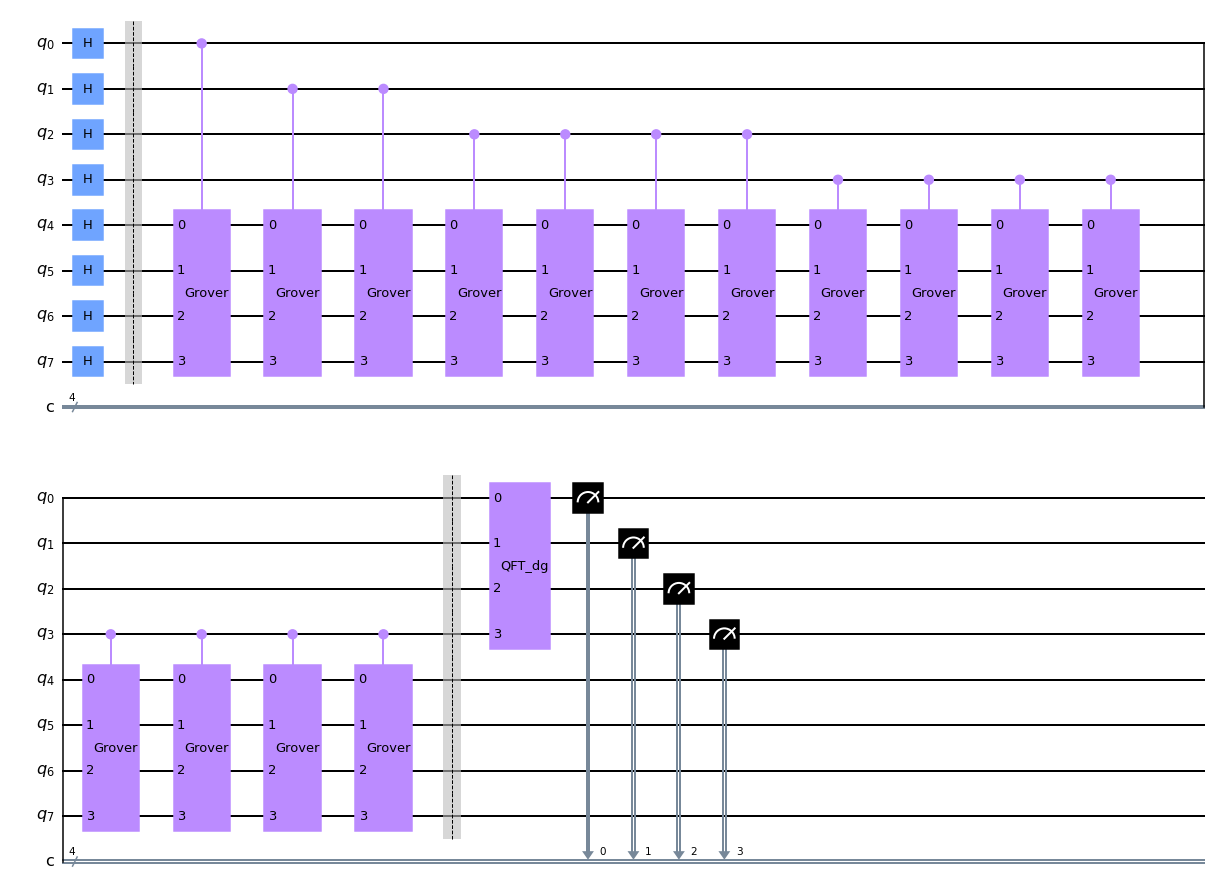

In [101]:
# we follow the procedure for QPE algorithm and apply the controlled grover gate
grover_gate = grover(search_qubits).to_gate(label = 'Grover').control()

for control_qubit in range(count_qubits):
    # apply the control phase
    for repetitions in range(2 ** control_qubit):
        circuit.append(grover_gate, [control_qubit] + [*range(count_qubits, count_qubits + search_qubits)])

circuit.barrier()

circuit.compose(QFT(count_qubits, do_swaps = True, inverse=True, name='QFT'), qubits = range(count_qubits), inplace = True)

circuit.measure(range(count_qubits), range(count_qubits))

%matplotlib inline
circuit.draw('mpl')

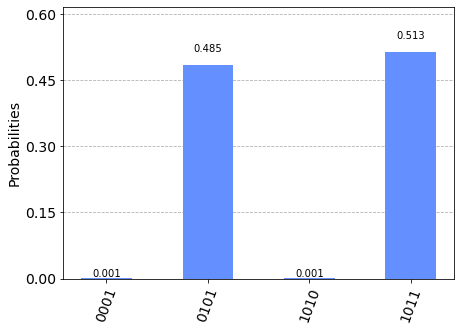

In [102]:
# simulate the circuit
from qiskit import Aer

simulator = simulator = Aer.get_backend('qasm_simulator')

result = execute(circuit, backend = simulator, shots = 1000).result()

counts = result.get_counts()

plot_histogram(counts)

* Readout gives 2 values with high probability, these correspond to eigenvalues $$ e^{i \theta}, e^{- i \theta} $$

For example for the measurement 1011 we get 

$$ \theta = (1/2 + 1/8 + 1/16) \times 2\pi = 4.3175 \approx 5 (solutions) $$